In [21]:
import pandas as pd
import numpy as np
from utilities_1 import compute_coulumb_matrixes
from utilities_1 import compute_coulumb_matrixes_pca
from utilities_1 import compute_fingerprints

from dataUtils import DataUtils
from model_utils import ModelUtils

from keras import Sequential
from keras.layers import Embedding, Conv1D, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import LeakyReLU

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data=pd.read_csv('cleaned_data_emission.tsv',sep='\t')
data.head()

,#,Name,Epsilon,Solvent,Quantum Yield,Solvent.1,File,File.1,Absorption,SMILES,Emission
0,1,Benzene,210,cyclohexane,0.053,hexane,A01_71-43-2_Benzene.abs.txt,A01_71-43-2_Benzene.ems.txt,254.75,C1=CC=CC=C1,287.0
1,2,Toluene,2860,cyclohexane,0.170,cyclohexane,A02_108-88-3_Toluene.abs.txt,A02_108-88-3_Toluene.ems.txt,261.75,CC1=CC=CC=C1,289.5
2,3,o-Xylene,254,cyclohexane,0.170,hexane,A03_95-47-6_o-Xylene.abs.txt,A03_95-47-6_o-Xylene.ems.txt,263.00,CC1=CC=CC=C1C,291.0
3,4,m-Xylene,284,cyclohexane,0.130,hexane,A04_108-38-3_m-Xylene.abs.txt,A04_108-38-3_m-Xylene.ems.txt,265.00,CC1=CC(=CC=C1)C,290.0
4,5,p-Xylene,770,cyclohexane,0.220,hexane,A05_106-42-3_p-Xylene.abs.txt,A05_106-42-3_p-Xylene.ems.txt,275.00,CC1=CC=C(C=C1)C,291.0


In [4]:
fp_dict = compute_fingerprints(data)

In [9]:
fps = np.array(list(map(np.array, pd.Series(fp_dict))))

In [7]:
y = np.array(data['Absorption'])

In [10]:
X_train, X_test, y_train, y_test = DataUtils.splitData(fps, y, ratio=0.20)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 137)
(59, 137)
(232, 1)
(59, 1)


In [11]:
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 137, 1)
(59, 137, 1)
(232, 1)
(59, 1)


In [12]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [13]:
model = Sequential()
#model.add(LeakyReLU(alpha=.3))
model.add(Conv1D(128, kernel_size=1, activation='relu',input_shape=(137, 1)))
model.add(BatchNormalization())
model.add(Flatten())
#model.add(Conv2D(4, kernel_size=(16,16), activation='relu',input_shape=(181, 181, 1)))
model.add(Dense(1028, activation='relu'))
#model.add(Conv2D(4, kernel_size=(3,3), activation='relu'))
#model.add(Conv1D(128,8,activation='linear'))
#model.add(LeakyReLU(alpha=.3))
#model.add(Conv1D(128,4,activation='linear'))

#model.add(Dense(250, activation='relu'))
#model.add(Dense(250, activation='relu'))
#model.add(Dense(512, activation='linear'))
#model.add(LeakyReLU(alpha=.3))
#model.add(Dense(512, activation='linear'))
#model.add(Dense(512, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.05))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 137, 128)          256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 137, 128)          512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 17536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1028)              18028036  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               263424    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

In [19]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [20]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=25, validation_data=(X_test,y_test))

Train on 232 samples, validate on 59 samples
Epoch 1/25
232/232 [==============================] - 9s 38ms/step - loss: 18803.0799 - coeff_determination: 0.1659 - lr: 0.0010 - val_loss: 19014.3066 - val_coeff_determination: 0.1153 - val_lr: 0.0010
Epoch 2/25
232/232 [==============================] - 8s 33ms/step - loss: 12463.0841 - coeff_determination: 0.4024 - lr: 0.0010 - val_loss: 20921.3301 - val_coeff_determination: 0.0265 - val_lr: 0.0010
Epoch 3/25
232/232 [==============================] - 8s 34ms/step - loss: 12048.1236 - coeff_determination: 0.3941 - lr: 0.0010 - val_loss: 15088.5498 - val_coeff_determination: 0.2979 - val_lr: 0.0010
Epoch 4/25
232/232 [==============================] - 8s 35ms/step - loss: 8145.1270 - coeff_determination: 0.5949 - lr: 0.0010 - val_loss: 21002.7578 - val_coeff_determination: 0.0227 - val_lr: 0.0010
Epoch 5/25
232/232 [==============================] - 8s 36ms/step - loss: 10974.5123 - coeff_determination: 0.4607 - lr: 0.0010 - val_loss: 160

KeyboardInterrupt: 

/Users/hunting/miniconda3/envs/SPEEDCOM/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


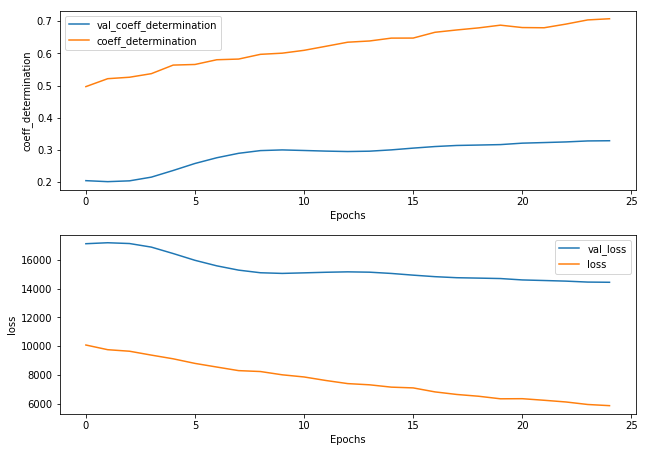

In [17]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

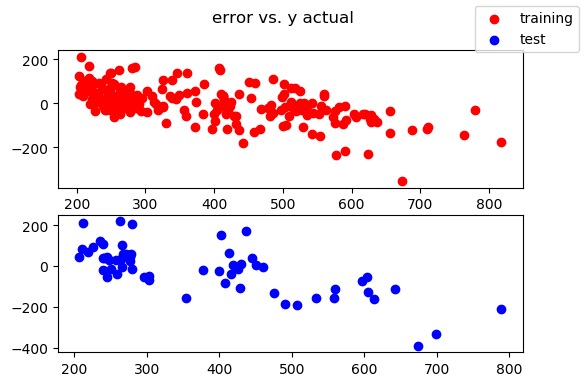

In [18]:
ModelUtils.plot_model_error(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model)

In [210]:
c_mtx_dict = compute_coulumb_matrixes(data)

In [211]:
len(c_mtx_dict)

291

In [214]:
c_mtx = np.array(list(map(np.array, pd.Series(c_mtx_dict))))

In [217]:
np.save('coumlomb_matrixes.npy', c_mtx)

In [219]:
c_mtx[0].shape

(181, 181)

In [507]:
y = np.array(data['Absorption'])

In [508]:
X_train, X_test, y_train, y_test = DataUtils.splitData(c_mtx, y, ratio=0.20)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 181, 181)
(59, 181, 181)
(232, 1)
(59, 1)


In [315]:
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 181, 181, 1)
(59, 181, 181, 1)
(232, 1)
(59, 1)


In [341]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [536]:
model = Sequential()
#model.add(LeakyReLU(alpha=.3))
model.add(Conv2D(8, kernel_size=(1,1), activation='relu',input_shape=(181, 181, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Conv2D(4, kernel_size=(16,16), activation='relu',input_shape=(181, 181, 1)))
model.add(Dense(1028, activation='relu'))
#model.add(Conv2D(4, kernel_size=(3,3), activation='relu'))
#model.add(Conv1D(128,8,activation='linear'))
#model.add(LeakyReLU(alpha=.3))
#model.add(Conv1D(128,4,activation='linear'))

#model.add(Dense(250, activation='relu'))
#model.add(Dense(250, activation='relu'))
#model.add(Dense(512, activation='linear'))
#model.add(LeakyReLU(alpha=.3))
#model.add(Dense(512, activation='linear'))
#model.add(Dense(512, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.05))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 181, 181, 8)       16        
_________________________________________________________________
batch_normalization_113 (Bat (None, 181, 181, 8)       32        
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 90, 90, 8)         0         
_________________________________________________________________
flatten_105 (Flatten)        (None, 64800)             0         
_________________________________________________________________
dense_386 (Dense)            (None, 1028)              66615428  
_________________________________________________________________
dropout_101 (Dropout)        (None, 1028)              0         
_________________________________________________________________
dense_387 (Dense)            (None, 256)               263424    
__________

In [534]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [523]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=25, validation_data=(X_test,y_test))

Train on 232 samples, validate on 59 samples
Epoch 1/200
232/232 [==============================] - 27s 115ms/step - loss: 157403.2360 - coeff_determination: -6.8221 - lr: 2.5000e-04 - val_loss: 156522.8750 - val_coeff_determination: -6.2830 - val_lr: 2.5000e-04
Epoch 2/200
232/232 [==============================] - 15s 66ms/step - loss: 147590.5706 - coeff_determination: -6.3405 - lr: 2.5000e-04 - val_loss: 143088.4062 - val_coeff_determination: -5.6579 - val_lr: 2.5000e-04
Epoch 3/200
232/232 [==============================] - 15s 67ms/step - loss: 134134.5525 - coeff_determination: -5.5906 - lr: 2.5000e-04 - val_loss: 125381.1250 - val_coeff_determination: -4.8340 - val_lr: 2.5000e-04
Epoch 4/200
232/232 [==============================] - 16s 67ms/step - loss: 115964.9141 - coeff_determination: -4.7436 - lr: 2.5000e-04 - val_loss: 104351.6328 - val_coeff_determination: -3.8555 - val_lr: 2.5000e-04
Epoch 5/200
232/232 [==============================] - 15s 67ms/step - loss: 97090.503

232/232 [==============================] - 16s 68ms/step - loss: 5125.6014 - coeff_determination: 0.7474 - lr: 2.5000e-04 - val_loss: 16139.9170 - val_coeff_determination: 0.2490 - val_lr: 2.5000e-04
Epoch 40/200
232/232 [==============================] - 16s 68ms/step - loss: 5333.2645 - coeff_determination: 0.7290 - lr: 2.5000e-04 - val_loss: 15750.3682 - val_coeff_determination: 0.2671 - val_lr: 2.5000e-04
Epoch 41/200
232/232 [==============================] - 16s 68ms/step - loss: 5455.7812 - coeff_determination: 0.7248 - lr: 2.5000e-04 - val_loss: 15415.2012 - val_coeff_determination: 0.2827 - val_lr: 2.5000e-04
Epoch 42/200
232/232 [==============================] - 16s 68ms/step - loss: 4525.1022 - coeff_determination: 0.7753 - lr: 2.5000e-04 - val_loss: 15098.6221 - val_coeff_determination: 0.2975 - val_lr: 2.5000e-04
Epoch 43/200
232/232 [==============================] - 16s 68ms/step - loss: 4549.2378 - coeff_determination: 0.7752 - lr: 2.5000e-04 - val_loss: 14880.8242 - v

232/232 [==============================] - 16s 69ms/step - loss: 3494.5369 - coeff_determination: 0.8245 - lr: 2.5000e-04 - val_loss: 15931.1533 - val_coeff_determination: 0.2587 - val_lr: 2.5000e-04
Epoch 78/200
232/232 [==============================] - 16s 68ms/step - loss: 3458.1860 - coeff_determination: 0.8298 - lr: 2.5000e-04 - val_loss: 16068.6025 - val_coeff_determination: 0.2523 - val_lr: 2.5000e-04
Epoch 79/200
232/232 [==============================] - 15s 67ms/step - loss: 3059.7369 - coeff_determination: 0.8479 - lr: 2.5000e-04 - val_loss: 16447.4512 - val_coeff_determination: 0.2347 - val_lr: 2.5000e-04
Epoch 80/200
232/232 [==============================] - 16s 68ms/step - loss: 2517.0719 - coeff_determination: 0.8760 - lr: 2.5000e-04 - val_loss: 16708.7949 - val_coeff_determination: 0.2225 - val_lr: 2.5000e-04
Epoch 81/200
232/232 [==============================] - 16s 67ms/step - loss: 2966.0423 - coeff_determination: 0.8528 - lr: 2.5000e-04 - val_loss: 16813.2441 - v

232/232 [==============================] - 16s 68ms/step - loss: 2505.7790 - coeff_determination: 0.8773 - lr: 2.5000e-04 - val_loss: 15674.2871 - val_coeff_determination: 0.2707 - val_lr: 2.5000e-04
Epoch 116/200
232/232 [==============================] - 16s 67ms/step - loss: 1561.1522 - coeff_determination: 0.9232 - lr: 2.5000e-04 - val_loss: 16181.4326 - val_coeff_determination: 0.2471 - val_lr: 2.5000e-04
Epoch 117/200
232/232 [==============================] - 16s 67ms/step - loss: 1730.1229 - coeff_determination: 0.9152 - lr: 2.5000e-04 - val_loss: 16921.4141 - val_coeff_determination: 0.2126 - val_lr: 2.5000e-04
Epoch 118/200
232/232 [==============================] - 16s 67ms/step - loss: 1814.1399 - coeff_determination: 0.9087 - lr: 2.5000e-04 - val_loss: 16845.7363 - val_coeff_determination: 0.2162 - val_lr: 2.5000e-04
Epoch 119/200
232/232 [==============================] - 16s 67ms/step - loss: 1550.9865 - coeff_determination: 0.9234 - lr: 2.5000e-04 - val_loss: 16027.0635

232/232 [==============================] - 15s 67ms/step - loss: 2624.7083 - coeff_determination: 0.8658 - lr: 2.5000e-04 - val_loss: 15245.0908 - val_coeff_determination: 0.2906 - val_lr: 2.5000e-04
Epoch 154/200
232/232 [==============================] - 16s 67ms/step - loss: 1134.4706 - coeff_determination: 0.9417 - lr: 2.5000e-04 - val_loss: 15598.9600 - val_coeff_determination: 0.2742 - val_lr: 2.5000e-04
Epoch 155/200
232/232 [==============================] - 16s 67ms/step - loss: 1171.8573 - coeff_determination: 0.9431 - lr: 2.5000e-04 - val_loss: 15792.4238 - val_coeff_determination: 0.2652 - val_lr: 2.5000e-04
Epoch 156/200
232/232 [==============================] - 16s 67ms/step - loss: 1670.5720 - coeff_determination: 0.9185 - lr: 2.5000e-04 - val_loss: 15338.2266 - val_coeff_determination: 0.2863 - val_lr: 2.5000e-04
Epoch 157/200
232/232 [==============================] - 15s 67ms/step - loss: 3014.2775 - coeff_determination: 0.8529 - lr: 2.5000e-04 - val_loss: 14741.6465

232/232 [==============================] - 15s 67ms/step - loss: 939.3814 - coeff_determination: 0.9520 - lr: 2.5000e-04 - val_loss: 13843.2158 - val_coeff_determination: 0.3559 - val_lr: 2.5000e-04
Epoch 192/200
232/232 [==============================] - 16s 67ms/step - loss: 1156.6902 - coeff_determination: 0.9437 - lr: 2.5000e-04 - val_loss: 13587.3096 - val_coeff_determination: 0.3678 - val_lr: 2.5000e-04
Epoch 193/200
232/232 [==============================] - 16s 67ms/step - loss: 799.6045 - coeff_determination: 0.9606 - lr: 2.5000e-04 - val_loss: 13972.5332 - val_coeff_determination: 0.3499 - val_lr: 2.5000e-04
Epoch 194/200
232/232 [==============================] - 16s 67ms/step - loss: 1314.3374 - coeff_determination: 0.9359 - lr: 2.5000e-04 - val_loss: 13887.2773 - val_coeff_determination: 0.3538 - val_lr: 2.5000e-04
Epoch 195/200
232/232 [==============================] - 15s 67ms/step - loss: 2587.0500 - coeff_determination: 0.8729 - lr: 2.5000e-04 - val_loss: 14120.1006 -

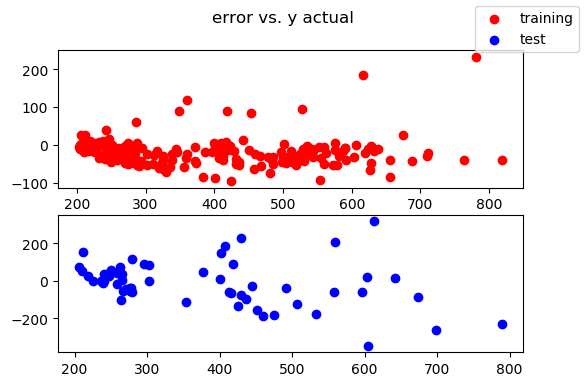

In [524]:
ModelUtils.plot_model_error(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model)

/Users/hunting/miniconda3/envs/SPEEDCOM/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


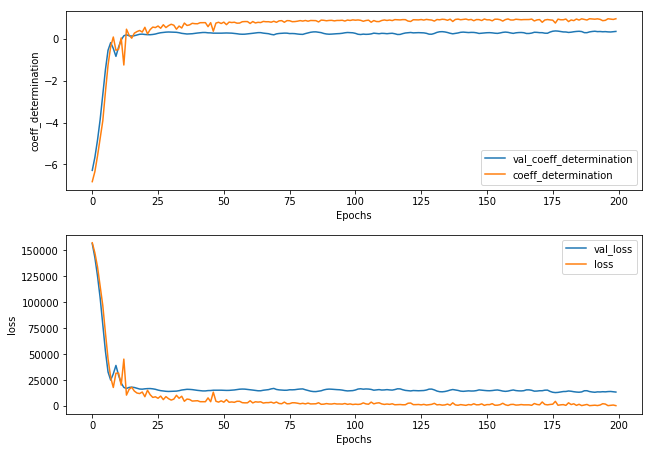

In [525]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

In [463]:
y = np.array(data['Quantum Yield'])

In [464]:
y = np.isnan(y).astype(int)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

numpy.float64

In [465]:
X_train, X_test, y_train, y_test = DataUtils.splitData(c_mtx, y, ratio=0.20)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 181, 181)
(59, 181, 181)
(232, 1)
(59, 1)


In [504]:
model2 = Sequential()
#model.add(LeakyReLU(alpha=.3))
#model.add(Conv2D(2, kernel_size=(10,10), activation='relu',input_shape=(181, 181, 1)))
model2.add(Flatten(input_shape=(181, 181)))
#model2.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(4, kernel_size=(16,16), activation='relu',input_shape=(181, 181, 1)))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.1))
#model.add(Conv2D(4, kernel_size=(3,3), activation='relu'))
#model.add(Conv1D(128,8,activation='linear'))
#model.add(LeakyReLU(alpha=.3))
#model.add(Conv1D(128,4,activation='linear'))

#model.add(Dense(250, activation='relu'))
#model.add(Dense(250, activation='relu'))
#model.add(Dense(512, activation='linear'))
#model.add(LeakyReLU(alpha=.3))
#model.add(Dense(512, activation='linear'))
model2.add(Dense(128, activation='relu'))
#model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_88 (Flatten)         (None, 32761)             0         
_________________________________________________________________
dense_334 (Dense)            (None, 128)               4193536   
_________________________________________________________________
dropout_88 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_335 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_336 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_337 (Dense)            (None, 1)                 129       
Total params: 4,226,689
Trainable params: 4,226,689
Non-trainable params: 0
_________________________________________________________________


In [505]:
optimizer = SGD(lr=0.001, momentum=0)
lr_metric = get_lr_metric(optimizer)
model2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', lr_metric])

In [506]:
history = model2.fit(x=X_train, y=y_train, batch_size=64, epochs=50, validation_data=(X_test,y_test))

Train on 232 samples, validate on 59 samples
Epoch 1/50
232/232 [==============================] - 9s 38ms/step - loss: 1.4544 - acc: 0.5129 - lr: 0.0050 - val_loss: 0.6104 - val_acc: 0.7458 - val_lr: 0.0050
Epoch 2/50
232/232 [==============================] - 1s 6ms/step - loss: 0.8743 - acc: 0.6853 - lr: 0.0050 - val_loss: 0.8991 - val_acc: 0.7119 - val_lr: 0.0050
Epoch 3/50
232/232 [==============================] - 1s 6ms/step - loss: 1.0142 - acc: 0.6595 - lr: 0.0050 - val_loss: 1.3434 - val_acc: 0.3898 - val_lr: 0.0050
Epoch 4/50
232/232 [==============================] - 1s 6ms/step - loss: 0.6037 - acc: 0.6983 - lr: 0.0050 - val_loss: 0.9282 - val_acc: 0.6102 - val_lr: 0.0050
Epoch 5/50
232/232 [==============================] - 1s 6ms/step - loss: 0.6621 - acc: 0.7198 - lr: 0.0050 - val_loss: 0.7769 - val_acc: 0.7627 - val_lr: 0.0050
Epoch 6/50
232/232 [==============================] - 1s 6ms/step - loss: 0.5389 - acc: 0.7974 - lr: 0.0050 - val_loss: 0.7619 - val_acc: 0.6271

KeyboardInterrupt: 

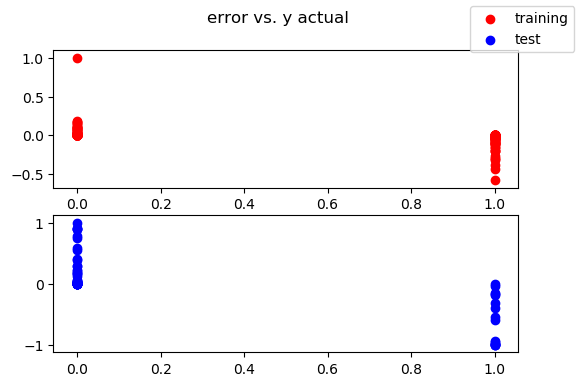

In [491]:
ModelUtils.plot_model_error(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model2)

In [495]:
model2.predict_classes(X_train)

array([[5.3566126e-03],
       [4.4996556e-05],
       [8.5634056e-06],
       [7.9107527e-03],
       [5.2261442e-02],
       [9.4506609e-01],
       [7.9343557e-01],
       [8.9338079e-02],
       [1.0000000e+00],
       [8.4444475e-01],
       [8.8344640e-01],
       [1.8155412e-01],
       [1.0821245e-01],
       [4.2256737e-01],
       [3.4097210e-04],
       [5.7448604e-04],
       [9.5361644e-01],
       [8.9515913e-03],
       [1.8273619e-03],
       [6.9078410e-01],
       [1.5555339e-10],
       [1.3533152e-03],
       [2.7729996e-08],
       [9.9999225e-01],
       [1.0000000e+00],
       [9.8182583e-01],
       [9.4779385e-03],
       [5.1986617e-03],
       [1.0000000e+00],
       [2.2147736e-02],
       [9.9829131e-01],
       [1.0429479e-02],
       [1.0000000e+00],
       [9.9997747e-01],
       [9.4285905e-03],
       [9.9999988e-01],
       [8.8345900e-02],
       [9.9955481e-01],
       [1.4201056e-06],
       [2.8446093e-03],
       [1.9983868e-03],
       [9.857385

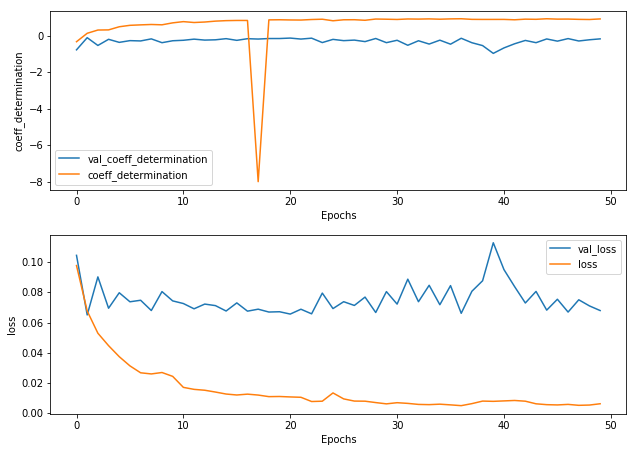

In [412]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

In [180]:
c_mtx_pc = compute_coulumb_matrixes_pca(data, cutoff_var_ratio=1e-7,SMILES_column='SMILES')

In [181]:
data['c_mtx_pc']=pd.Series(c_mtx_pc)

In [182]:
X_mtx_pc=np.array(list(map(np.array, data['c_mtx_pc'])))

In [183]:
y = np.array(data['Absorption'])

In [228]:
X_train, X_test, y_train, y_test = DataUtils.splitData(X_mtx_pc, y, ratio=0.20)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 125)
(59, 125)
(232, 1)
(59, 1)


In [226]:
X_train.shape

(232, 125)

In [229]:
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 125, 1)
(59, 125, 1)
(232, 1)
(59, 1)


In [92]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [191]:
model = Sequential()
#model.add(Dense(1024, input_shape=(63,)))
model.add(Conv1D(128,16,activation='linear',input_shape=(125,1)))
#model.add(BatchNormalization())
model.add(Conv1D(128,8,activation='linear'))
model.add(LeakyReLU(alpha=.3))
model.add(Conv1D(128,4,activation='linear'))
model.add(LeakyReLU(alpha=.3))
model.add(Flatten())
#model.add(Dense(250, activation='relu'))
#model.add(Dense(250, activation='relu'))
#model.add(Dense(512, activation='linear'))
#model.add(LeakyReLU(alpha=.3))
model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.3))
model.add(Dense(256, activation='linear'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_65 (Conv1D)           (None, 110, 128)          2176      
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 103, 128)          131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 103, 128)          0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 100, 128)          65664     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 100, 128)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_89 (Dense)             (None, 512)               6554112   
__________

In [192]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [193]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=100, validation_data=(X_test,y_test))

Train on 232 samples, validate on 59 samples
Epoch 1/100
232/232 [==============================] - 13s 57ms/step - loss: 156366.8163 - coeff_determination: -6.6924 - lr: 2.5000e-04 - val_loss: 149452.3125 - val_coeff_determination: -5.9540 - val_lr: 2.5000e-04
Epoch 2/100
232/232 [==============================] - 10s 44ms/step - loss: 159341.5189 - coeff_determination: -6.8512 - lr: 2.5000e-04 - val_loss: 127880.0547 - val_coeff_determination: -4.9503 - val_lr: 2.5000e-04
Epoch 3/100
232/232 [==============================] - 10s 45ms/step - loss: 125663.9294 - coeff_determination: -5.1806 - lr: 2.5000e-04 - val_loss: 103107.2578 - val_coeff_determination: -3.7976 - val_lr: 2.5000e-04
Epoch 4/100
232/232 [==============================] - 11s 47ms/step - loss: 102207.4523 - coeff_determination: -4.0018 - lr: 2.5000e-04 - val_loss: 81723.8750 - val_coeff_determination: -2.8026 - val_lr: 2.5000e-04
Epoch 5/100
232/232 [==============================] - 11s 49ms/step - loss: 93735.1716 

KeyboardInterrupt: 

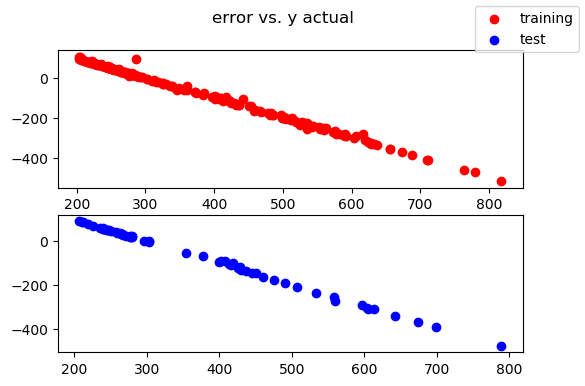

In [179]:
ModelUtils.plot_model_error(X_train,X_test,y_train.reshape(1,-1), y_test.reshape(1,-1),model)

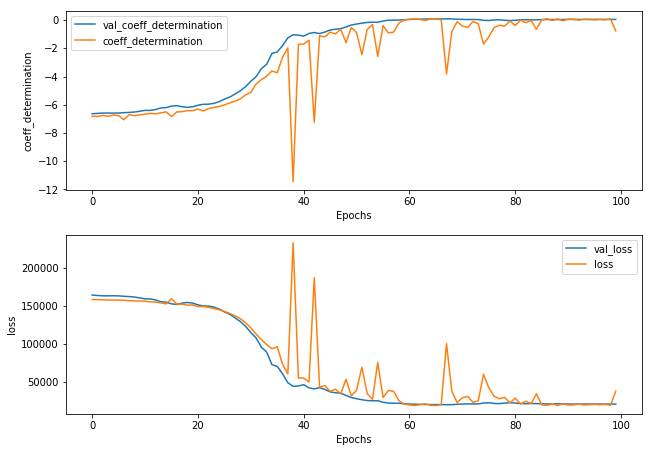

In [168]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

In [ ]:
c_mtx_eig = compute_coulumb_matrixes(data, use_eigval=True, SMILES_column='SMILES')

In [537]:
20 / 2

10.0

In [539]:
int(11 / 2)

5